In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
import csv

#pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time

from config.config_baseline import *
from models import Baseline
from data_loader import DRIVE
from train import train, predict
from loss import *
from augments import *

import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.rcParams['figure.figsize'] = [10, 5]

In [2]:
train_transform = aug_minor
test_transform = aug_minor

trainset = DRIVE(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=3)
testset = DRIVE(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=3)

print('Loaded %d training images' % len(trainset))
print('Loaded %d test images' % len(testset))

Loaded 20 training images
Loaded 20 test images


In [3]:
# Testing of IoU
transform = transforms.Compose([transforms.PILToTensor()])

y_real = transform(Image.open('/dtu/datasets1/02514/DRIVE/training/mask/21_training_mask.gif'))
y_pred = transform(Image.open('/dtu/datasets1/02514/DRIVE/training/1st_manual/21_manual1.gif'))
IoU(y_real, y_real)


tensor(1.)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = Baseline().to(device)

cuda


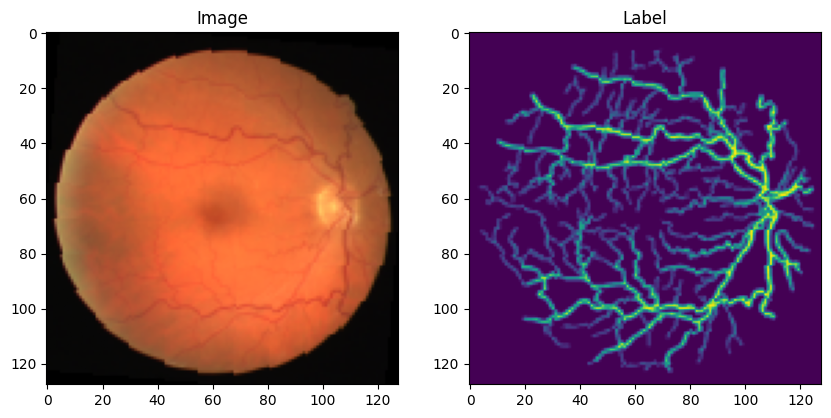

In [5]:
im_train, mask_train = trainset[1]
im_train = im_train.permute(1, 2, 0)
mask_train = mask_train.permute(1, 2, 0)
fig, axs = plt.subplots(1,2)
axs[0].imshow(im_train)
axs[0].set_title("Image")
axs[1].imshow(mask_train)
axs[1].set_title("Label")
plt.show()

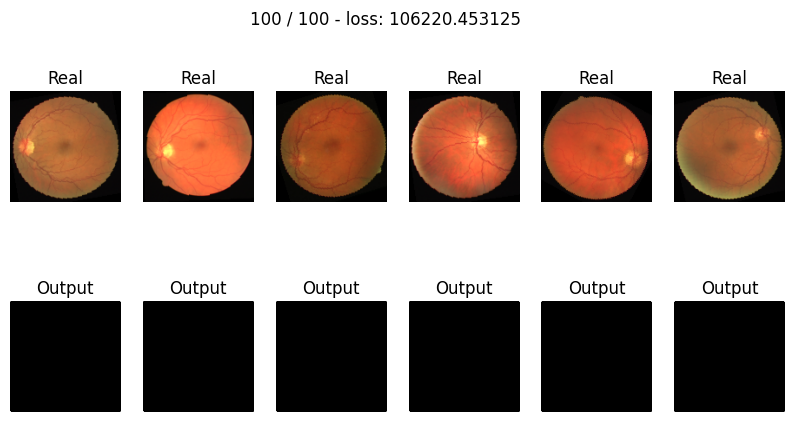

In [6]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
results = train(model, optimizer, focal_loss, EPOCHS, train_loader, test_loader, device)

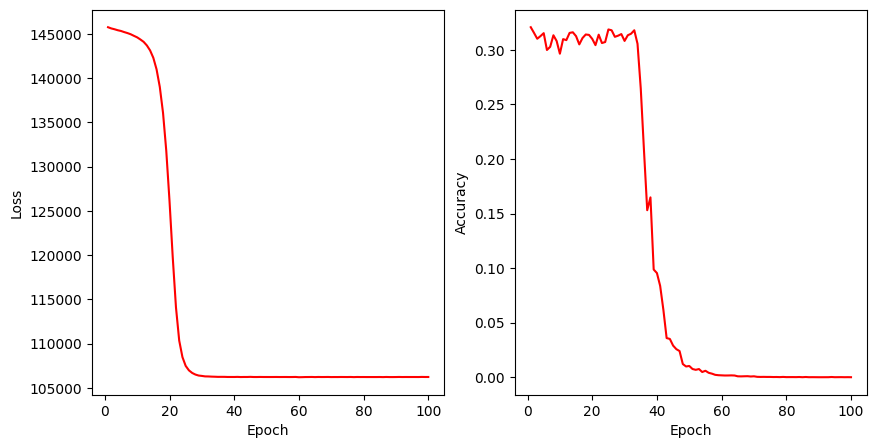

In [7]:
fig, axs = plt.subplots(1,2)
axs[0].plot([e for e in range(1, EPOCHS+1)], results['train_loss'], c='r', label='train')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

axs[1].plot([e for e in range(1, EPOCHS+1)], results['train_acc'], c='r', label='train')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
plt.savefig(f"results/{MODEL_NAME}_optim={OPTIM}_lr={LEARNING_RATE}_epochs={EPOCHS}_augs={AUGS}_loss={LOSS}.png")
plt.show()

In [8]:
# saving results
d = results
filename = f'results/{MODEL_NAME}_{EPOCHS}_epochs_{LEARNING_RATE:.0e}_lr_{OPTIM}_optim_augs={AUGS}_loss={LOSS}.csv'
with open(filename, 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerow(d.keys())
    writer.writerows(zip(*d.values()))